Optical SETI project: Are our candidates airglow lines?
=======================================================
This notebook compares the wavelengths of the best OSETI candidates against natural airglow lines.
* The HARPS pipeline shifts observed spectra from the Earth reference frame into the barycentric frame, and stores the barycentric radial velocity in the `HIERARCH ESO DRS BERV` header.  We shift the spectrum back into the Earth frame using that same velocity.
* Airglow data are from Hanuschik, 2003, "A flux-calibrated, high-resolution atlas of optical sky emission from UVES", doi:10.1051/0004-6361:20030885 , downloaded from https://vizier.cds.unistra.fr/viz-bin/VizieR-2 in .fits format and stored as `hanuschik_airglow.fits`.

Setup and import stuff:

In [66]:
%matplotlib widget

In [67]:
from astroquery.eso import Eso
eso = Eso()
from pathlib import Path
eso_cache_folder = Path(eso.cache_location)
import harpscompare
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

Login if needed.

In [68]:
if not eso.authenticated():
    eso.login(username="goodmanj", store_password=True)

INFO: Authenticating goodmanj on www.eso.org... [astroquery.eso.core]
INFO: Authentication successful! [astroquery.eso.core]


In [69]:
specfiles = ["ADP.2018-02-12T01_02_31.348.fits","ADP.2018-04-11T01_01_47.531.fits","ADP.2014-09-16T11_06_51.280.fits","ADP.2014-09-26T16_52_17.823.fits",
             "ADP.2014-09-26T16_52_17.823.fits","ADP.2014-10-06T10_04_15.220.fits","ADP.2014-10-02T10_02_27.423.fits"]
starnames = ["CD-312415","GJ317","HD96673","HIP87607","HIP87607","HIP87607","GJ4291"]
lambs = [3931.24,4662.77,3931.31,3784.09,4042.7,5454.0,3841.74]
# Benji's data for comparison and cross-check
#lambs_airglow_benji = [[3931.0825],[4662.0542,4662.232],[3931.0825],[3784.8796],[3841.3704,3841.6980,3842.1606]]
vbary_benji = [-15.983,-17.533,15.715,-23.949,-23.949,-23.949,20.089]

Download files if necessary.

In [70]:
fullspecfiles = [eso_cache_folder/file for file in specfiles]
print(fullspecfiles)
print([file.exists() for file in fullspecfiles])

for i in range(len(specfiles)):
    if not fullspecfiles[i].exists():
        print(fullspecfiles[i].stem)
        download_name =  str(fullspecfiles[i].stem).replace("_",":")
        print(download_name)
        harpscompare.download_spectrum(download_name)

[WindowsPath('C:/Users/goodm/.astropy/cache/astroquery/Eso/ADP.2018-02-12T01_02_31.348.fits'), WindowsPath('C:/Users/goodm/.astropy/cache/astroquery/Eso/ADP.2018-04-11T01_01_47.531.fits'), WindowsPath('C:/Users/goodm/.astropy/cache/astroquery/Eso/ADP.2014-09-16T11_06_51.280.fits'), WindowsPath('C:/Users/goodm/.astropy/cache/astroquery/Eso/ADP.2014-09-26T16_52_17.823.fits'), WindowsPath('C:/Users/goodm/.astropy/cache/astroquery/Eso/ADP.2014-09-26T16_52_17.823.fits'), WindowsPath('C:/Users/goodm/.astropy/cache/astroquery/Eso/ADP.2014-10-06T10_04_15.220.fits'), WindowsPath('C:/Users/goodm/.astropy/cache/astroquery/Eso/ADP.2014-10-02T10_02_27.423.fits')]
[True, True, True, True, True, True, True]


Extract barycentric earth radial velocity (`berv`) from FITS header.  Compare against velocities provided by Benji.

In [71]:
berv = []
for fname in fullspecfiles:
    specfits = fits.open(fname)
    berv.append(specfits[0].header['HIERARCH ESO DRS BERV'])
    specfits.close()
print(["%5.3f" % v for v in berv])
print(["%5.3f" % v for v in vbary_benji])

['-16.003', '-19.628', '15.709', '-23.959', '-23.959', '20.915', '19.955']
['-15.983', '-17.533', '15.715', '-23.949', '-23.949', '-23.949', '20.089']


Doppler shift function

In [72]:
def doppler(wave,v):
    c = 2.998e5 # km/s
    beta = v/c
    return wave*np.sqrt((1-beta)/(1+beta))

Read entire airglow database

In [73]:
airglow_database = fits.open("hanuschik_airglow.fits")  # Merge Table 5 and 6 from Hanuschik
airglow_data_1 = airglow_database[1].data
airglow_data_2 = airglow_database[2].data
airglow_lambda = np.concatenate((airglow_data_1['lambda'],airglow_data_2['lambda']))
airglow_fwhm = np.concatenate((airglow_data_1['fwhm'],airglow_data_2['fwhm']))

Box-and-whisker plot function

In [74]:
# Draw a line with a box around it to indicate the position and width of a spectral line.
import matplotlib.patches as patches
def myboxplot(ax,x,y,width,height,color='r'):
    ax.plot([x,x],[y,y+height],color)
    ax.add_patch(patches.Rectangle((x-width/2,y+height/4),width,height/2,edgecolor=color,facecolor='none'))

For each star spectrum:
* shift its wavelengths (and the wavelength of the identified spike) into the terrestrial reference frame.  Then plot:
* * The spectrum
* * The identified spike location with a red dashed line
* * The locations of all nearby airglow lines using a box plot to indicate their FWHM.
* Title with the star name and file name.
* Adjust axis limits and margins.

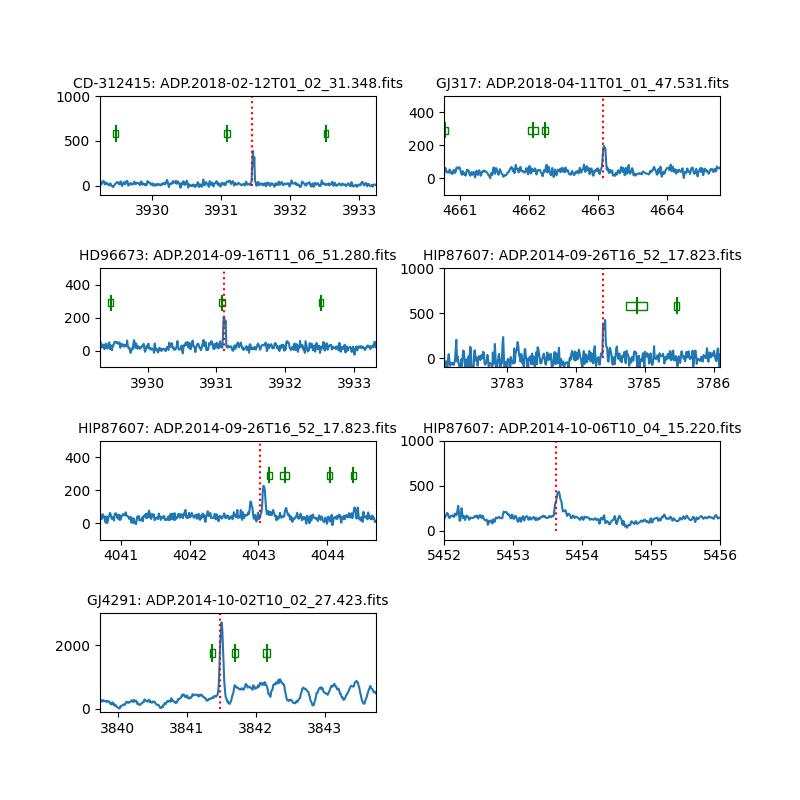

In [75]:
wavelength_range =2 # Range of wavelengths to show
plt.figure(2)
plt.figure(2).set_size_inches(8,8)
plt.clf()
yaxlim = [1000,500,500,1000,500,1000,3000];          # custom y-axis limits for each graph
for i in range(len(fullspecfiles)):
    specfits = fits.open(fullspecfiles[i])
    wave = specfits[1].data[0][0]  # wavelength for each spectrum
    arr1 = specfits[1].data[0][1]  # spectral amplitude for each spectrum
    specfits.close()

    # Shift into Earth reference frame
    wave_earthref = doppler(wave,berv[i])
    lamb_earthref = doppler(lambs[i],berv[i])
    # Subplots
    plt.subplot(4,2,i+1)
    ax = plt.gca()
    plt.plot(wave_earthref,arr1)
    plt.plot([lamb_earthref,lamb_earthref],[0, yaxlim[i]],'r:')
    plt.xlim(lambs[i]-wavelength_range,lambs[i]+wavelength_range)
    plt.ylim(-100,yaxlim[i])
    # Select nearby airglow lines
    mask = (airglow_lambda > lambs[i]-wavelength_range) & (airglow_lambda < lambs[i]+wavelength_range)
    for alamb,afwhm in zip(airglow_lambda[mask],airglow_fwhm[mask]):
        # Plot them using myboxplot, defined above
        myboxplot(ax,alamb,yaxlim[i]/2,afwhm,yaxlim[i]/6,'g')
    plt.title('%s: %s' % (starnames[i],specfiles[i]),fontsize=10)
plt.subplots_adjust(wspace=.25,hspace=.75)
plt.show()

We see that in the terrestrial reference frame, only one of our candidates is close to an airglow line: HD96673.  This was also identified by Benji's analysis as having a "Predicted Doppler Velocity" fairly close to the "Barrycorr Velocity" (differing by 2 km/s): using spectral linewidths to compare, we can see that the FWHM of airglow and candidate overlap significantly.

None of the other candidates is anywhere near an airglow line.

Things I'm still confused about: Our "list of candidate signals" includes 9 candidates from 7 stars, but only 5 candidates from 5 stars are listed in Benji's analysis.  I added the other observations of HIP87607, but HIP59341 and HD127423 are missing in action and not included here.

In [77]:
# Save figure
plt.savefig("airglow_reanalysis.pdf", format="pdf", bbox_inches="tight")